In [1]:
from gptutils import *
from transformers import GPTNeoXForCausalLM, AutoTokenizer, GPT2LMHeadModel

/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [115]:
%config InlineBackend.figure_formats = ['svg']

In [324]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [325]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
tokenizer = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-350m")
model = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-350m")

In [323]:
print(model.embed_out.bias)

None


In [102]:
sent = "I am hungry and I am happy and I am"
inputs = tokenizer(sent, return_tensors="pt")
# del inputs['token_type_ids']
outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

# Softmax autoencoder

In [194]:
norms, probs, maxes, probs_raw = [], [], [], []
for i in tqdm(range(0, model.embed_in.weight.size()[0], 1000)):
    emb = torch.matmul(model.embed_in.weight[i:i+1000], model.embed_in.weight.t())
    unemb = torch.softmax(emb, dim=-1)
    norm = torch.norm(unemb, dim=-1)
    max = torch.argmax(unemb, dim=-1)
    norms.extend(norm.tolist())
    probs.extend(torch.diagonal(unemb[:,i:i+1000]).tolist())
    maxes.extend(max.tolist())
    probs_raw.extend(torch.diagonal(emb[:,i:i+1000]).tolist())
    del emb
    del unemb
    del norm

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:07<00:00,  6.90it/s]


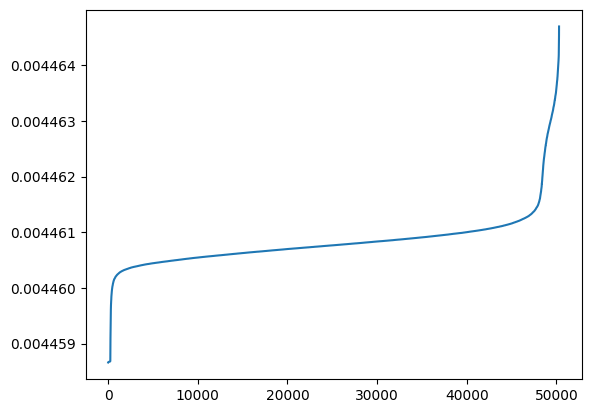

In [195]:
plt.plot(sorted(norms))

In [245]:
t = tokenizer.encode('I am Barack')[-1]
dot = torch.matmul(model.gpt_neox.embed_in.weight[t] * 100, model.gpt_neox.embed_in.weight.t())
a = torch.softmax(dot, dim=-1)
print(a)
top = torch.topk(a, k=20)
for index, val in zip(top.indices, top.values):
    print(tokenizer.decode(index).replace(' ', '_'), f'{float(val.detach()):.3%}')

tensor([3.4680e-34, 1.1336e-34, 1.1692e-34,  ..., 1.4156e-34, 2.3207e-34,
        3.1399e-34], grad_fn=<SoftmaxBackward0>)
_Barack 100.000%
_Donald 0.000%
_Hillary 0.000%
Obama 0.000%
_Obama 0.000%
_Barry 0.000%
_Bernie 0.000%
_Michelle 0.000%
_Vladimir 0.000%
_Ronald 0.000%
Donald 0.000%
_Romney 0.000%
_Boris 0.000%
_Mitt 0.000%
_McCain 0.000%
_Ricky 0.000%
_Obamacare 0.000%
_Palin 0.000%
_Larry 0.000%
_quarterback 0.000%


['                                                                          ', '\n\n          ', '                                                             ', '', '         \n ', '\n         ', '\n           ', '                                                          ', '                                        ', '                                                                     ', '\n                              ', '', '\n                     ', '\n                                        ', '                                            ', '\n\n   ', '                                                                 ', '', '\n                           ', '\n                    ', '                                                                                                                                                                                                                                ', '\n\n           ', ' \n           ', '\n\n              ', '               

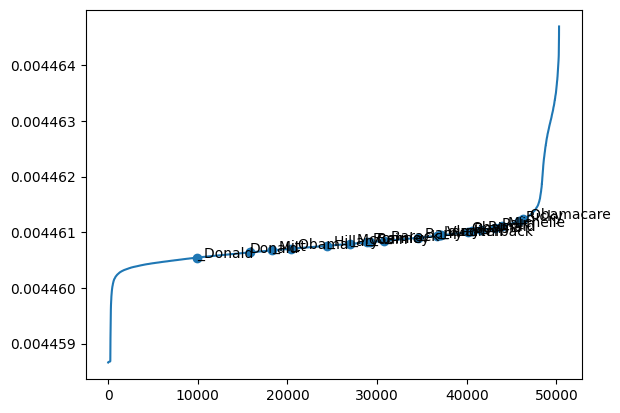

In [234]:
s = torch.topk(torch.tensor(norms), k=len(norms)).indices
print([tokenizer.decode(i) for i in s[-50:]])
d = {}
for i, j in enumerate(s):
    d[int(j)] = len(norms) - int(i) - 1

print(s)
plt.plot(sorted(norms))
t = tokenizer.encode('I am Barack')[-1]
cos = torch.nn.CosineSimilarity(eps=1e-6, dim=-1)

def check(plot=False):
    C = top.indices.detach()
    X = [d[int(i)] for i in top.indices.detach()]
    Y = torch.tensor(norms)[top.indices]
    if plot:
        plt.scatter(X, Y)
    print(f'\n{"tok":<15} {"norm":>6} {"dot":>6}' +
             f' {"cos":>6}')
    for c, x, y in zip(C, X, Y):
        wrd = tokenizer.decode(c).replace(' ', '_')
        if plot:
            plt.text(x=x, y=y, s=wrd)
        print(f'{wrd:<15} {y:>6.3f} {torch.dot(model.gpt_neox.embed_in.weight[C[0]], model.gpt_neox.embed_in.weight[c]):>6.3f}' +
             f' {cos(model.gpt_neox.embed_in.weight[C[0]], model.gpt_neox.embed_in.weight[c]):>6.3f}')
    print()

top = torch.topk(torch.softmax(torch.matmul(model.gpt_neox.embed_in.weight[t], model.gpt_neox.embed_in.weight.t()), dim=-1), k=20)
check(True)
top = torch.topk(cos(model.gpt_neox.embed_in.weight, model.gpt_neox.embed_in.weight[t]), k=20)
check()

# Passive subject extraction

In [145]:
template = "The <theme1> was <verb1.0> by <agent1>. The <theme2> was <verb2.0> by <agent2>. Who <verb2.1> the"
vars = {
    "theme1": ["food", "thing", "item", "man"],#, "woman", "person", "stick",
               #"tree", "egg", "cheese", "dog", "bird", "meat"],
    "verb1": [("eaten", "ate"), ("beaten", "beat"), ("hit", "hit")],# ("held", "held"), ("rubbed", "rubbed"),
             #("pulled", "pulled")],#, ("seen", "saw"), ("drunk", "drank"), ("thrown", "threw"), ("cut", "cut"),
              #("robbed"), ("robbed")],
    "agent1": ["Tim", "Bob", "Ram"] #"Roshan", "Aslam", "Tina", "Stacy", "Andy", "Robert"]
}
vars["theme2"] = vars["theme1"]
vars["verb2"] = vars["verb1"]
vars["agent2"] = vars["agent1"]
s = [x for x in make_sents(model, tokenizer, template, vars) if x[2]['theme1'] != x[2]['theme2'] and
     x[2]['verb1'] != x[2]['verb2'] and x[2]['agent1'] != x[2]['agent2']]
len(s)

432

In [146]:
attns = compare_attention_and_probs(model, tokenizer, s, 'theme1', fr=-1, to=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [00:17<00:00, 24.69it/s]

[((11, 7), 84.17830306105316), ((10, 1), 81.60017612203956), ((10, 2), 69.87651741690934), ((9, 6), 63.679086605552584), ((9, 1), 63.53990327939391), ((10, 8), 62.61461717262864), ((10, 4), 52.72931251116097), ((9, 9), 51.275768239051104), ((10, 7), 51.01311045628972), ((10, 6), 45.83555028703995)]


In [147]:
attns = compare_attention_and_probs(model, tokenizer, s, 'theme2', fr=-1, to=3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [00:16<00:00, 25.71it/s]

[((10, 4), 118.50756558403373), ((10, 11), 114.41340013407171), ((11, 7), 107.28727184049785), ((11, 5), 107.06937702000141), ((10, 1), 95.6290568113327), ((9, 6), 90.68900503963232), ((10, 7), 89.70026117097586), ((9, 1), 89.60167560633272), ((9, 9), 81.53401558846235), ((11, 10), 75.20782762486488)]


In [137]:
print(tokenizer.decode(s[0][0][0]))

The thing was beaten by Bob. The food was eaten by Tim. Who beat the


[0.38834571 0.14082008]


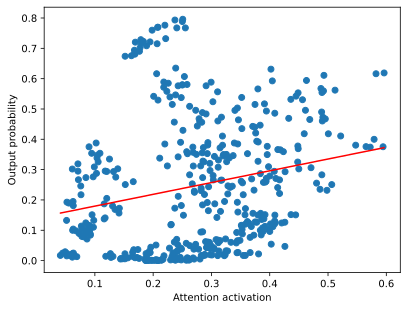

In [148]:
graph(attns, (10, 4))

# Logit Lens

In [80]:
tot = 0
transitions = [0 for _ in range(13)]
probs = [0 for _ in range(13)]
comps = [[0 for y in range(13)] for x in range(13)]
entropies = [0 for _ in range(13)]

for sent in tqdm(data[:10]):
    text = sent.metadata['text']
    preds, inputs, outputs = get_all_logits(model, tokenizer, text)
    
    for token in range(outputs.hidden_states[0].size()[1]):
        for layer in range(len(outputs.hidden_states)):
            entropy = torch.special.entr(sm(model.embed_out(outputs.hidden_states[layer][0][token])))
            entropy = torch.sum(entropy)
            entropies[layer] += entropy
            
    lens = logit_lens(model, tokenizer, outputs, output_layer=lambda m: m.embed_out)
    for token in lens:
        tot += 1
        for layer in range(len(token)):
            probs[layer] += token[layer][0][1]
            if layer > 0:
                if token[layer][0][0] != token[layer - 1][0][0]: transitions[layer] += 1
            for layer2 in range(layer):
                if token[layer][0][0] != token[layer2][0][0]: comps[layer][layer2] += 1
torch.tensor(transitions) / tot

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.02s/it]


tensor([0.0000, 1.0000, 0.8077, 0.9017, 0.8248, 0.8419, 0.8034, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])

<BarContainer object of 13 artists>

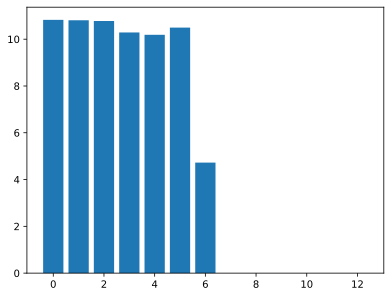

In [81]:
plt.bar(list(range(13)), torch.tensor(entropies) / tot)

<BarContainer object of 13 artists>

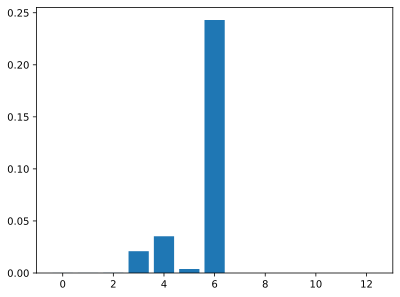

In [82]:
plt.bar(list(range(13)), torch.tensor(probs) / tot)

<BarContainer object of 13 artists>

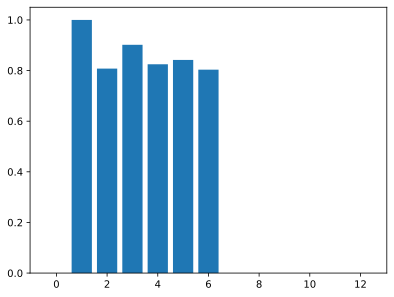

In [83]:
plt.bar(list(range(13)), torch.tensor(transitions) / tot)

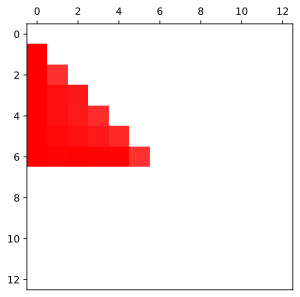

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.8077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.9231, 0.9017, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.9359, 0.8974, 0.8248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.9573, 0.9316, 0.8932, 0.8419, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.9786, 0.9915, 0.9744, 0.9701, 0.8034, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000,

In [87]:
draw_tensor(model, tokenizer, (torch.tensor(comps) / tot))
torch.tensor(comps) / tot

In [302]:
ret, inputs, outputs = get_all_logits(model, tokenizer, "1 2")
ret

[[('.', 0.12046689540147781),
  (',', 0.07334654033184052),
  (')', 0.04352195933461189),
  ('}', 0.04048847034573555),
  ('/', 0.0326794870197773)],
 [('.', 0.19793936610221863),
  ('\n', 0.06964924186468124),
  (' 1', 0.042536403983831406),
  (',', 0.04082198068499565),
  (' 2', 0.04024927318096161)]]

In [303]:
for _, i in enumerate(logit_lens(model, tokenizer, outputs, output_layer=lambda m: m.embed_out)[-1]):
    w = i[0][0].replace(" ", "_").replace("\n", "\\n")
    print(f'| {_-1:<5} | {w:<15} | {i[0][1]:>10.4f} | ' + 
             f'{torch.norm(outputs.hidden_states[_][0][-1], dim=-1):>8.3f} | ' +
             f'{cos(outputs.hidden_states[_][0][-1], outputs.hidden_states[_ - 1][0][-1]):>6.3f}')

| -1    | board           |     0.0000 |    0.810 |  0.035
| 0     | _\-             |     0.0002 |   15.672 |  0.144
| 1     | _\-             |     0.0002 |   16.631 |  0.862
| 2     | ainer           |     0.0003 |   19.881 |  0.869
| 3     | ainer           |     0.0002 |   19.878 |  0.883
| 4     | px              |     0.0002 |   18.636 |  0.824
| 5     | \;              |     0.0003 |   19.218 |  0.897
| 6     | p               |     0.0002 |   18.313 |  0.918
| 7     | p               |     0.0003 |   18.686 |  0.931
| 8     | p               |     0.0005 |   20.106 |  0.941
| 9     | p               |     0.0005 |   21.530 |  0.954
| 10    | p               |     0.0006 |   21.898 |  0.951
| 11    | p               |     0.0005 |   22.749 |  0.957
| 12    | :               |     0.0009 |   23.487 |  0.954
| 13    | .               |     0.0017 |   24.871 |  0.958
| 14    | \n              |     0.0024 |   25.942 |  0.965
| 15    | \n              |     0.0047 |   27.873 |  0.9

In [232]:
for i in range(25):
    print(torch.norm(outputs.hidden_states[i][0][-1], dim=-1))

tensor(0.6980, grad_fn=<CopyBackwards>)
tensor(12.5763, grad_fn=<CopyBackwards>)
tensor(15.6436, grad_fn=<CopyBackwards>)
tensor(17.9747, grad_fn=<CopyBackwards>)
tensor(18.4961, grad_fn=<CopyBackwards>)
tensor(17.5849, grad_fn=<CopyBackwards>)
tensor(18.4414, grad_fn=<CopyBackwards>)
tensor(17.3342, grad_fn=<CopyBackwards>)
tensor(16.2860, grad_fn=<CopyBackwards>)
tensor(16.9158, grad_fn=<CopyBackwards>)
tensor(18.1224, grad_fn=<CopyBackwards>)
tensor(19.2397, grad_fn=<CopyBackwards>)
tensor(20.3696, grad_fn=<CopyBackwards>)
tensor(23.1726, grad_fn=<CopyBackwards>)
tensor(23.1869, grad_fn=<CopyBackwards>)
tensor(25.2487, grad_fn=<CopyBackwards>)
tensor(27.8733, grad_fn=<CopyBackwards>)
tensor(32.0984, grad_fn=<CopyBackwards>)
tensor(37.7853, grad_fn=<CopyBackwards>)
tensor(41.9867, grad_fn=<CopyBackwards>)
tensor(46.0968, grad_fn=<CopyBackwards>)
tensor(50.3342, grad_fn=<CopyBackwards>)
tensor(55.0294, grad_fn=<CopyBackwards>)
tensor(54.8911, grad_fn=<CopyBackwards>)
tensor(70.6808, g

# EWT

In [34]:
import conllu

with open('en_ewt-ud-train.conllu.txt', 'r') as fin:
    data = conllu.parse(fin.read())

In [41]:
top = []
for sent in tqdm(data[:500]):
    text = sent.metadata['text']
#     print(text)
    preds, inputs, outputs = get_all_logits(model, tokenizer, text, k=1)
    toks = [tokenizer.decode(x) for x in inputs['input_ids'][0]]
    for i in range(len(preds)):
        if preds[i][0][1] > 0.9:
            top.append([i, preds[i][0], toks])
#             print('--->', f"{tokenizer.decode([inputs['input_ids'][0][i]]):<20}", preds[i][0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 39.71it/s]


In [46]:
Counter([(toks[pos], pred[0]) for pos, pred, toks in top]).most_common()

[(('www', '.'), 27),
 (('ob', 'yl'), 21),
 (('’', 's'), 10),
 ((' Sri', ' Lanka'), 8),
 ((' able', ' to'), 5),
 ((' number', ' of'), 4),
 (('ar', 'raf'), 4),
 (('S', '.'), 4),
 (('.', 'S'), 4),
 ((' going', ' to'), 3),
 (('aze', 'era'), 3),
 ((' United', ' States'), 3),
 ((' Prime', ' Minister'), 3),
 ((' Mush', 'ar'), 3),
 (('o', '-'), 3),
 ((' Nad', 'u'), 3),
 (('h', 'ales'), 3),
 (('ales', 'e'), 3),
 (('ung', 'a'), 3),
 ((' part', ' of'), 3),
 ((' opposed', ' to'), 2),
 ((' assass', 'inated'), 2),
 ((' don', "'t"), 2),
 ((' Fall', 'ujah'), 2),
 ((' mos', 'ques'), 2),
 ((' increase', ' in'), 2),
 (('articles', '/'), 2),
 (('index', '.'), 2),
 (('com', '/'), 2),
 ((' lack', ' of'), 2),
 ((' willing', ' to'), 2),
 ((' sort', ' of'), 2),
 ((' unable', ' to'), 2),
 ((' overthrow', ' of'), 2),
 ((' Security', ' Council'), 2),
 ((',', '000'), 2),
 ((' such', ' as'), 2),
 ((' influence', ' of'), 2),
 (('hal', 'a'), 2),
 (('TT', 'E'), 2),
 ((' env', 'oy'), 2),
 ((' fact', ' that'), 2),
 ((' 

In [ ]:
import csv

with open('sure_predictions.csv', 'w') as fout:
    writer = csv.writer(fout)

# Copying heads

In [108]:
vocab = model.lm_head.out_features
vocab

50257

  0%|                                                                                                                       | 0/8 [00:00<?, ?it/s]

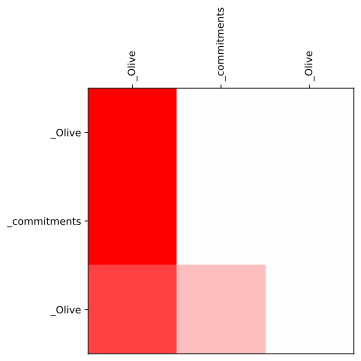

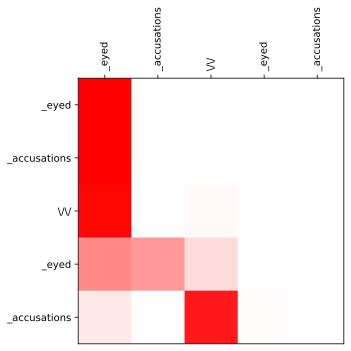

 25%|███████████████████████████▊                                                                                   | 2/8 [00:00<00:00, 11.26it/s]

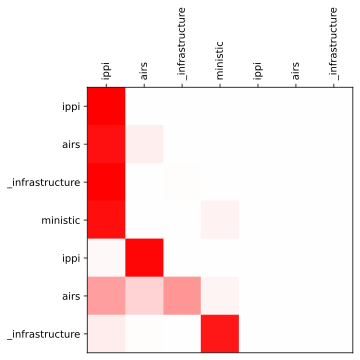

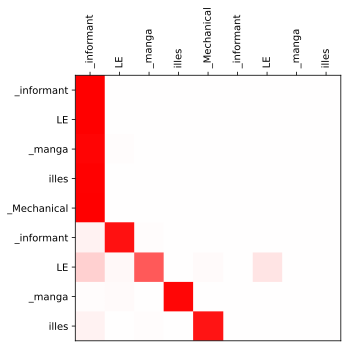

 50%|███████████████████████████████████████████████████████▌                                                       | 4/8 [00:00<00:00, 11.03it/s]

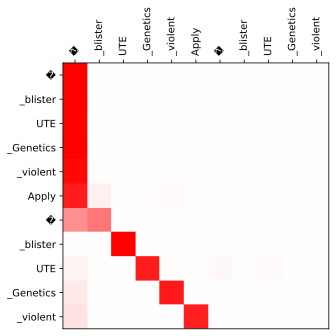

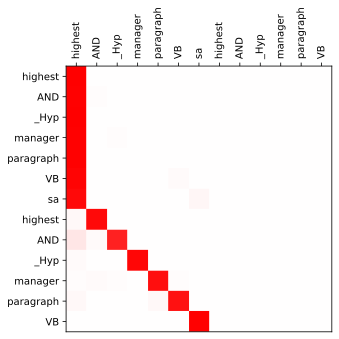

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 6/8 [00:00<00:00,  9.79it/s]

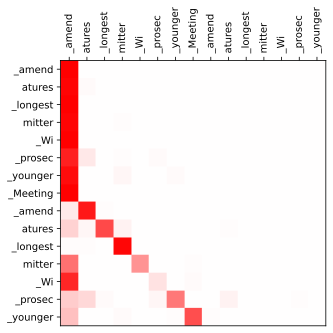

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 7/8 [00:00<00:00,  9.26it/s]

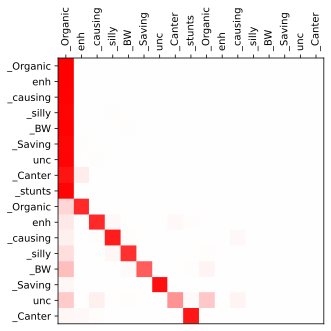

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.27it/s]


In [112]:
attns = Counter()

tot = 0
for length in tqdm(range(2, 10)):
    for _ in range(1):
        seq = torch.randint(0, vocab, (length,)).tolist()
        seq.extend(seq[:-1])
        next = seq[length - 1]
        preds, inputs, outputs = get_final_logits(model, tokenizer, input_ids=torch.tensor([seq]), k=1)
        draw_tensor(model, tokenizer, outputs.attentions[7][0][10], inputs={'input_ids': torch.tensor([seq])})
        for activ, layer, head in get_top_attentions(model, tokenizer, -1, length - 1, outputs)[:5]:
            attns[(layer, head)] += activ
        tot += 1

for i in attns:
    attns[i] /= tot

In [113]:
attns.most_common()

[((5, 5), 0.8114388510584831),
 ((7, 10), 0.6857781484723091),
 ((5, 1), 0.45844991505146027),
 ((10, 7), 0.4527975022792816),
 ((5, 0), 0.4234471917152405),
 ((6, 9), 0.22429056465625763),
 ((10, 11), 0.20076211541891098),
 ((5, 8), 0.18706512451171875),
 ((4, 11), 0.12499698996543884),
 ((9, 9), 0.11487150192260742),
 ((10, 6), 0.10749495774507523),
 ((7, 2), 0.10651052743196487),
 ((11, 10), 0.10253141075372696),
 ((8, 6), 0.10031064599752426),
 ((10, 1), 0.0946822464466095),
 ((2, 2), 0.0913180410861969),
 ((2, 5), 0.08689145743846893)]